#[UCI Heart Disease Data](https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data)(Kaggle) - klasyfikacja choroby serca



In [23]:
import kagglehub
import os
import pandas as pd

path = kagglehub.dataset_download("redwankarimsony/heart-disease-data")

print("Path to dataset files:", path)
print(os.listdir(path))

df = pd.read_csv(os.path.join(path, "heart_disease_uci.csv"))


Path to dataset files: /root/.cache/kagglehub/datasets/redwankarimsony/heart-disease-data/versions/6
['heart_disease_uci.csv']


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


#Wymiary
Rekordy: 920
Kolumny: 16 cech

#Opis cech:

###Numeryczne (int64 / float64): 8 kolumn

id – unikalny identyfikator pacjenta

age – wiek pacjenta

trestbps – ciśnienie krwi w spoczynku

chol – cholesterol w mg/dl

thalach – maksymalne tętno osiągnięte

oldpeak – ST depression wywołane wysiłkiem

ca – liczba naczyń głównych pokolorowanych fluoroskopowo

num – przewidywana etykieta choroby serca


###Kategoryczne / obiektowe (object): 8 kolumn

sex – płeć

dataset – pochodzenie badania

cp – typ bólu w klatce piersiowej

fbs – cukier na czczo > 120 mg/dl (True/False)

restecg – wynik EKG w spoczynku

exang – dławica wywołana wysiłkiem

slope – nachylenie ST segment

thal – typ defektu (normal, fixed defect, reversible defect)


###Brakujące dane

trestbps – 861/920 → ok. 6.4% braków

chol – 890/920 → ok. 3.3% braków

fbs – 830/920 → ok. 9.8% braków

slope – 611/920 → ok. 33.5% braków

ca – 309/920 → ok. 66.4% braków

thal – 434/920 → ok. 52.8% braków

In [25]:
n_rows, n_cols = df.shape
print(f"\nLiczba rekordów: {n_rows}")
print(f"Liczba cech (kolumn): {n_cols}")

print("\n--- Przykładowe wiersze ---")
print(df.head())

print("\n--- Statystyki opisowe ---")
print(df.describe())



Liczba rekordów: 920
Liczba cech (kolumn): 16

--- Przykładowe wiersze ---
   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable de

In [26]:
import numpy as np

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

target_col = 'num' if 'num' in df.columns else None
if target_col is not None:
    if target_col in num_cols:
        num_cols.remove(target_col)
    if target_col in cat_cols:
        cat_cols.remove(target_col)

print("num_cols:", num_cols)
print("cat_cols:", cat_cols)

num_cols: ['id', 'age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
cat_cols: ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']


In [27]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer, KNNImputer

num_df = df[num_cols].copy()
cat_df = df[cat_cols].copy()

half = len(num_cols) // 2
num_easy = num_cols[:half]
num_hard = num_cols[half:]

simple_imputer = SimpleImputer(strategy='mean')
num_easy_imputed = pd.DataFrame(simple_imputer.fit_transform(df[num_easy]), columns=num_easy)

knn_imputer = KNNImputer(n_neighbors=5)
num_hard_imputed = pd.DataFrame(knn_imputer.fit_transform(df[num_hard]), columns=num_hard)

num_imputed = pd.concat([num_easy_imputed, num_hard_imputed], axis=1)

cat_imputer = SimpleImputer(strategy='most_frequent')
cat_imputed = pd.DataFrame(cat_imputer.fit_transform(cat_df), columns=cat_cols)

df_imputed = pd.concat([num_imputed, cat_imputed], axis=1)

print("✅ Dane uzupełnione:")
print(df_imputed.info())

✅ Dane uzupełnione:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    float64
 1   age       920 non-null    float64
 2   trestbps  920 non-null    float64
 3   chol      920 non-null    float64
 4   thalch    920 non-null    float64
 5   oldpeak   920 non-null    float64
 6   ca        920 non-null    float64
 7   sex       920 non-null    object 
 8   dataset   920 non-null    object 
 9   cp        920 non-null    object 
 10  fbs       920 non-null    object 
 11  restecg   920 non-null    object 
 12  exang     920 non-null    object 
 13  slope     920 non-null    object 
 14  thal      920 non-null    object 
dtypes: float64(7), object(8)
memory usage: 107.9+ KB
None


In [28]:
from sklearn.preprocessing import OrdinalEncoder

df_encoded = df_imputed.copy()

ordinal_features = {
    'cp': ['asymptomatic', 'non-anginal', 'atypical angina', 'typical angina'],
    'restecg': ['normal', 'st-t abnormality', 'lv hypertrophy'],
    'slope': ['upsloping', 'flat', 'downsloping'],
    'thal': ['normal', 'reversable defect', 'fixed defect']
}

encoder = OrdinalEncoder(categories=[ordinal_features[col] for col in ordinal_features])
df_encoded[list(ordinal_features.keys())] = encoder.fit_transform(df_encoded[list(ordinal_features.keys())])

nominal_features = ['sex', 'dataset', 'fbs', 'exang']
df_encoded = pd.get_dummies(df_encoded, columns=nominal_features, drop_first=True)

print("✅ Wszystkie kolumny zakodowane numerycznie:")
print(df_encoded.info())
df_encoded.head()


✅ Wszystkie kolumny zakodowane numerycznie:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     920 non-null    float64
 1   age                    920 non-null    float64
 2   trestbps               920 non-null    float64
 3   chol                   920 non-null    float64
 4   thalch                 920 non-null    float64
 5   oldpeak                920 non-null    float64
 6   ca                     920 non-null    float64
 7   cp                     920 non-null    float64
 8   restecg                920 non-null    float64
 9   slope                  920 non-null    float64
 10  thal                   920 non-null    float64
 11  sex_Male               920 non-null    bool   
 12  dataset_Hungary        920 non-null    bool   
 13  dataset_Switzerland    920 non-null    bool   
 14  dataset_VA Lon

,id,age,trestbps,chol,thalch,oldpeak,ca,cp,restecg,slope,thal,sex_Male,dataset_Hungary,dataset_Switzerland,dataset_VA Long Beach,fbs_True,exang_True
0,1.0,63.0,145.0,233.0,150.0,2.3,0.0,3.0,2.0,2.0,2.0,True,False,False,False,True,False
1,2.0,67.0,160.0,286.0,108.0,1.5,3.0,0.0,2.0,1.0,0.0,True,False,False,False,False,True
2,3.0,67.0,120.0,229.0,129.0,2.6,2.0,0.0,2.0,1.0,1.0,True,False,False,False,False,True
3,4.0,37.0,130.0,250.0,187.0,3.5,0.0,1.0,0.0,2.0,0.0,True,False,False,False,False,False
4,5.0,41.0,130.0,204.0,172.0,1.4,0.0,2.0,2.0,0.0,0.0,False,False,False,False,False,False


In [29]:
# =============================================================================
# EKSTRAKCJA CECH - Feature Engineering
# =============================================================================
# Wstaw ten blok PO linii z "df_encoded.head()" (linia ~142)
# i PRZED sekcją "display(df_encoded.describe().T)"

print("\n" + "="*70)
print("EKSTRAKCJA CECH - Feature Engineering")
print("="*70)

# 1. Cardiovascular Risk Score - zagregowany wskaźnik ryzyka
print("\n[1/5] Tworzenie: cv_risk_score (Cardiovascular Risk Score)")
df_encoded['cv_risk_score'] = (
    (df_encoded['age'] - 40) * 0.1 +           # wiek powyżej 40 lat
    (df_encoded['chol'] - 200) * 0.05 +        # cholesterol powyżej normy (200 mg/dl)
    (df_encoded['trestbps'] - 120) * 0.08 +    # ciśnienie powyżej normy (120 mmHg)
    df_encoded['oldpeak'] * 2                   # depresja ST (silny wskaźnik)
).clip(lower=0)  # nie może być ujemny

print(f"   Zakres: {df_encoded['cv_risk_score'].min():.2f} - {df_encoded['cv_risk_score'].max():.2f}")
print(f"   Średnia: {df_encoded['cv_risk_score'].mean():.2f}")

# 2. Heart Reserve Capacity - wydolność serca
print("\n[2/5] Tworzenie: heart_reserve (Heart Reserve Capacity)")
df_encoded['heart_reserve'] = df_encoded['thalch'] / (df_encoded['oldpeak'] + 1)
# Im wyższe tętno przy niższym oldpeak = lepiej
# +1 żeby uniknąć dzielenia przez 0

print(f"   Zakres: {df_encoded['heart_reserve'].min():.2f} - {df_encoded['heart_reserve'].max():.2f}")
print(f"   Średnia: {df_encoded['heart_reserve'].mean():.2f}")

# 3. Age Category - kategorie wiekowe
print("\n[3/5] Tworzenie: age_category (kategorie wiekowe)")
df_encoded['age_category'] = pd.cut(
    df_encoded['age'],
    bins=[0, 45, 55, 65, 100],
    labels=[0, 1, 2, 3]  # 0=młody, 1=średni, 2=senior, 3=starszy
).astype(float)  # konwersja na float dla zgodności

age_counts = df_encoded['age_category'].value_counts().sort_index()
print(f"   Rozkład: 0(młody)={age_counts.get(0.0,0)}, 1(średni)={age_counts.get(1.0,0)}, "
      f"2(senior)={age_counts.get(2.0,0)}, 3(starszy)={age_counts.get(3.0,0)}")

# 4. Triple Risk Flag - flaga potrójnego ryzyka
print("\n[4/5] Tworzenie: triple_risk (flaga potrójnego ryzyka)")
df_encoded['triple_risk'] = (
    (df_encoded['chol'] > 240) &         # wysoki cholesterol
    (df_encoded['trestbps'] > 140) &     # wysokie ciśnienie
    (df_encoded['age'] > 55)             # wiek >55
).astype(int)

triple_count = df_encoded['triple_risk'].sum()
triple_pct = (triple_count / len(df_encoded)) * 100
print(f"   Pacjentów z potrójnym ryzykiem: {triple_count} ({triple_pct:.1f}%)")

# 5. Exercise Tolerance Score - tolerancja wysiłku
print("\n[5/5] Tworzenie: exercise_tolerance (tolerancja wysiłku)")
df_encoded['exercise_tolerance'] = (
    (df_encoded['thalch'] > 150).astype(int) * 2 +      # dobre maksymalne tętno
    (df_encoded['oldpeak'] < 1).astype(int) * 2 +       # niska depresja ST
    (~df_encoded['exang_True']).astype(int)             # brak dławicy wysiłkowej
)  # Skala 0-5

exercise_dist = df_encoded['exercise_tolerance'].value_counts().sort_index()
print(f"   Rozkład (0-5): {dict(exercise_dist)}")

print("\n" + "="*70)
print(f"✅ Dodano 5 nowych cech. Łącznie cech: {len(df_encoded.columns)}")
print("="*70 + "\n")


EKSTRAKCJA CECH - Feature Engineering

[1/5] Tworzenie: cv_risk_score (Cardiovascular Risk Score)
   Zakres: 0.00 - 24.35
   Średnia: 5.21

[2/5] Tworzenie: heart_reserve (Heart Reserve Capacity)
   Zakres: -1790.00 - inf
   Średnia: inf

[3/5] Tworzenie: age_category (kategorie wiekowe)
   Rozkład: 0(młody)=196, 1(średni)=317, 2(senior)=325, 3(starszy)=82

[4/5] Tworzenie: triple_risk (flaga potrójnego ryzyka)
   Pacjentów z potrójnym ryzykiem: 49 (5.3%)

[5/5] Tworzenie: exercise_tolerance (tolerancja wysiłku)
   Rozkład (0-5): {0: np.int64(220), 1: np.int64(103), 2: np.int64(98), 3: np.int64(285), 4: np.int64(19), 5: np.int64(195)}

✅ Dodano 5 nowych cech. Łącznie cech: 22



#Imputacja i kodowanie

1. **Imputacja braków**  
   - Dane numeryczne podzielono na dwa podzbiory:
     - Podzbiór A: imputacja prostą metodą (średnia)  
     - Podzbiór B: imputacja bardziej zaawansowaną metodą (KNNImputer)  
   - Dla danych kategorycznych zastosowano imputację wartościami najczęstszymi (`most_frequent`).

2. **Kodowanie zmiennych kategorycznych**  
   - Zmienne z naturalnym porządkiem (np. `cp`, `restecg`, `slope`, `thal`) zakodowano za pomocą **OrdinalEncoder**, by zachować sens kolejności.  
   - Pozostałe zmienne nominalne (np. `sex`, `dataset`, `fbs`, `exang`) zakodowano metodą **One-Hot Encoding**, usuwając jedną referencyjną kategorię (drop_first=True), aby uniknąć współliniowości.

Po tych operacjach wszystkie cechy mają typ numeryczny (float lub bool), bez brakujących wartości — dane są gotowe do analizy statystycznej i modelowania.  


### Zmodyfikowane i zakodowane cechy

1. **`sex`** → zastąpiono przez kolumnę binarną `sex_Male`  
   - Wartość `True` oznacza mężczyznę, `False` – kobietę.  

2. **`dataset`** → zastąpiono trzema kolumnami logicznymi:  
   - `dataset_Hungary`, `dataset_Switzerland`, `dataset_VA Long Beach`  
   - Brak wartości w tych kolumnach (wszystkie `False`) oznacza dane z **Cleveland** (usunięta referencja po One-Hot Encoding).

3. **`cp` (chest pain type)** → zakodowano liczbowo metodą **OrdinalEncoder**:  
   - 0 – typical angina  
   - 1 – atypical angina  
   - 2 – non-anginal  
   - 3 – asymptomatic  

4. **`restecg`** → zakodowano liczbowo metodą **OrdinalEncoder**:  
   - 0 – normal  
   - 1 – stt abnormality  
   - 2 – lv hypertrophy  

5. **`slope`** → zakodowano liczbowo metodą **OrdinalEncoder**:  
   - 0 – upsloping  
   - 1 – flat  
   - 2 – downsloping  

6. **`thal`** → zakodowano liczbowo metodą **OrdinalEncoder**:  
   - 0 – normal  
   - 1 – fixed defect  
   - 2 – reversible defect  

7. **`fbs` i `exang`** → zastąpione przez kolumny binarne (`fbs_True`, `exang_True`)  
   - Wartość `True` oznacza odpowiednio: cukier na czczo >120 mg/dl / wystąpienie dławicy przy wysiłku.


Wszystkie pozostałe kolumny (`age`, `trestbps`, `chol`, `thalch`, `oldpeak`, `ca`) zachowały oryginalną postać liczbową (float), jedynie uzupełniono w nich brakujące wartości.


In [30]:
display(df_encoded.describe().T)

,count,mean,std,min,25%,50%,75%,max
id,920.0,460.500000,265.725422,1.0,230.7500,460.500,690.25,920.00
age,920.0,53.510870,9.424685,28.0,47.0000,54.000,60.00,77.00
trestbps,920.0,132.132404,18.443895,0.0,120.0000,130.000,140.00,200.00
chol,920.0,198.970642,109.467013,0.0,175.0000,223.000,267.00,603.00
thalch,920.0,137.741997,25.359888,60.0,120.0000,140.000,157.00,202.00
oldpeak,920.0,0.877083,1.062098,-2.6,0.0000,0.600,1.50,6.20
ca,920.0,0.766553,0.674078,0.0,0.2000,0.800,1.20,3.00
cp,920.0,0.750000,0.930969,0.0,0.0000,0.000,1.00,3.00
restecg,920.0,0.603261,0.805443,0.0,0.0000,0.000,1.00,2.00
slope,920.0,0.847826,0.516007,0.0,1.0000,1.000,1.00,2.00


In [31]:
# Rozkład wieku pacjentów + średni cholesterol w tych przedziałach
print("\n=== Rozkład wieku pacjentów ===")
age_bins = pd.cut(df_encoded['age'], bins=5)
age_distribution = df_encoded['age'].value_counts(bins=5).sort_index()

print("Liczba pacjentów w przedziałach wiekowych:")
print(age_distribution)

print("\nŚredni cholesterol (chol) w tych samych przedziałach wiekowych:")
print(df_encoded.groupby(age_bins)['chol'].mean().round(2))



=== Rozkład wieku pacjentów ===
Liczba pacjentów w przedziałach wiekowych:
(27.95, 37.8]     49
(37.8, 47.6]     190
(47.6, 57.4]     350
(57.4, 67.2]     277
(67.2, 77.0]      54
Name: count, dtype: int64

Średni cholesterol (chol) w tych samych przedziałach wiekowych:
age
(27.951, 37.8]    211.62
(37.8, 47.6]      211.81
(47.6, 57.4]      203.94
(57.4, 67.2]      186.34
(67.2, 77.0]      174.87
Name: chol, dtype: float64


/tmp/ipython-input-2671056806.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_encoded.groupby(age_bins)['chol'].mean().round(2))


In [32]:
# Średnie wartości ciśnienia i cholesterolu w zależności od kraju pochodzenia
print("\n=== Średnie ciśnienie i cholesterol w zależności od kraju ===")
country_cols = ['dataset_Hungary', 'dataset_Switzerland', 'dataset_VA Long Beach']
df_encoded['dataset_origin'] = df_encoded[country_cols].idxmax(axis=1).replace({
    'dataset_Hungary': 'Hungary',
    'dataset_Switzerland': 'Switzerland',
    'dataset_VA Long Beach': 'VA Long Beach'
})
df_encoded.loc[(df_encoded[country_cols] == False).all(axis=1), 'dataset_origin'] = 'Cleveland'
print(df_encoded.groupby('dataset_origin')[['trestbps', 'chol']].mean().round(2))


=== Średnie ciśnienie i cholesterol w zależności od kraju ===
                trestbps    chol
dataset_origin                  
Cleveland         131.68  246.32
Hungary           132.59  247.19
Switzerland       130.24    0.00
VA Long Beach     133.31  178.73


In [33]:
print("\n=== Średnie tętno maksymalne (thalch) w zależności od płci ===")
print(df_encoded.groupby('sex_Male')['thalch'].mean().rename({True: "Mężczyźni", False: "Kobiety"}))


=== Średnie tętno maksymalne (thalch) w zależności od płci ===
sex_Male
Kobiety      146.135052
Mężczyźni    135.499225
Name: thalch, dtype: float64


In [34]:
# Częstość występowania dławicy wysiłkowej (exang) w zależności od płci
print("\n=== Dławica wysiłkowa (exang_True) w zależności od płci ===")
print(df_encoded.groupby('sex_Male')['exang_True'].mean().rename({True: "Mężczyźni", False: "Kobiety"}))


=== Dławica wysiłkowa (exang_True) w zależności od płci ===
sex_Male
Kobiety      0.221649
Mężczyźni    0.404959
Name: exang_True, dtype: float64


In [35]:
print("\n=== Korelacje między wybranymi zmiennymi ===")
corr_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
print(df_encoded[corr_cols].corr().round(2))


=== Korelacje między wybranymi zmiennymi ===
           age  trestbps  chol  thalch  oldpeak
age       1.00      0.24 -0.09   -0.35     0.25
trestbps  0.24      1.00  0.09   -0.10     0.16
chol     -0.09      0.09  1.00    0.24     0.05
thalch   -0.35     -0.10  0.24    1.00    -0.15
oldpeak   0.25      0.16  0.05   -0.15     1.00


In [36]:
if 'num' not in df_encoded.columns and 'num' in df.columns:
    df_encoded['num'] = df['num']

In [37]:
print("=== Średni wiek pacjentów z chorobą i bez choroby, z podziałem na płeć ===")

# Obliczamy średni wiek pacjentów z chorobą i bez choroby (num > 0 oznacza obecność choroby)
age_by_sex_disease = df_encoded.groupby(['sex_Male', df_encoded['num'] > 0])['age'].mean().unstack()
age_by_sex_disease.columns = ['Brak choroby', 'Choroba serca']
age_by_sex_disease.index = ['Kobiety', 'Mężczyźni']
print(age_by_sex_disease.round(1))

# Udział przypadków choroby w każdej grupie płci
print("\n=== Odsetek osób z chorobą serca w zależności od płci ===")
disease_rate_by_sex = df_encoded.groupby('sex_Male')['num'].apply(lambda x: (x > 0).mean())
disease_rate_by_sex.index = ['Kobiety', 'Mężczyźni']
print((disease_rate_by_sex * 100).round(1).astype(str) + '%')


=== Średni wiek pacjentów z chorobą i bez choroby, z podziałem na płeć ===
           Brak choroby  Choroba serca
Kobiety            51.2           56.2
Mężczyźni          50.2           55.9

=== Odsetek osób z chorobą serca w zależności od płci ===
Kobiety      25.8%
Mężczyźni    63.2%
Name: num, dtype: object


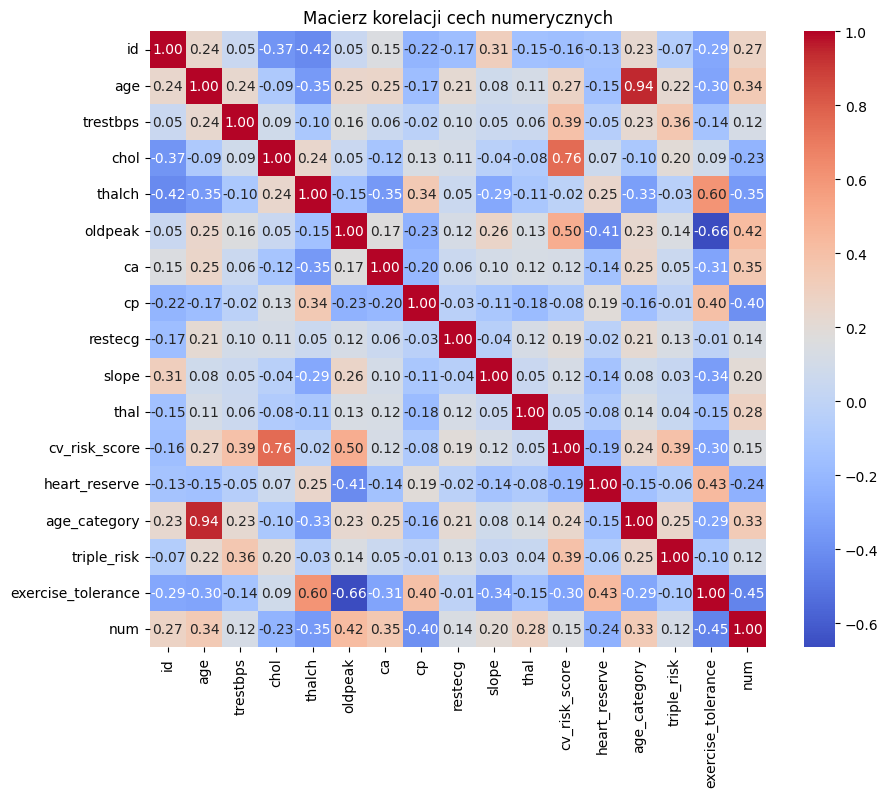

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
corr_matrix = df_encoded.select_dtypes(include='number').corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Macierz korelacji cech numerycznych")
plt.show()


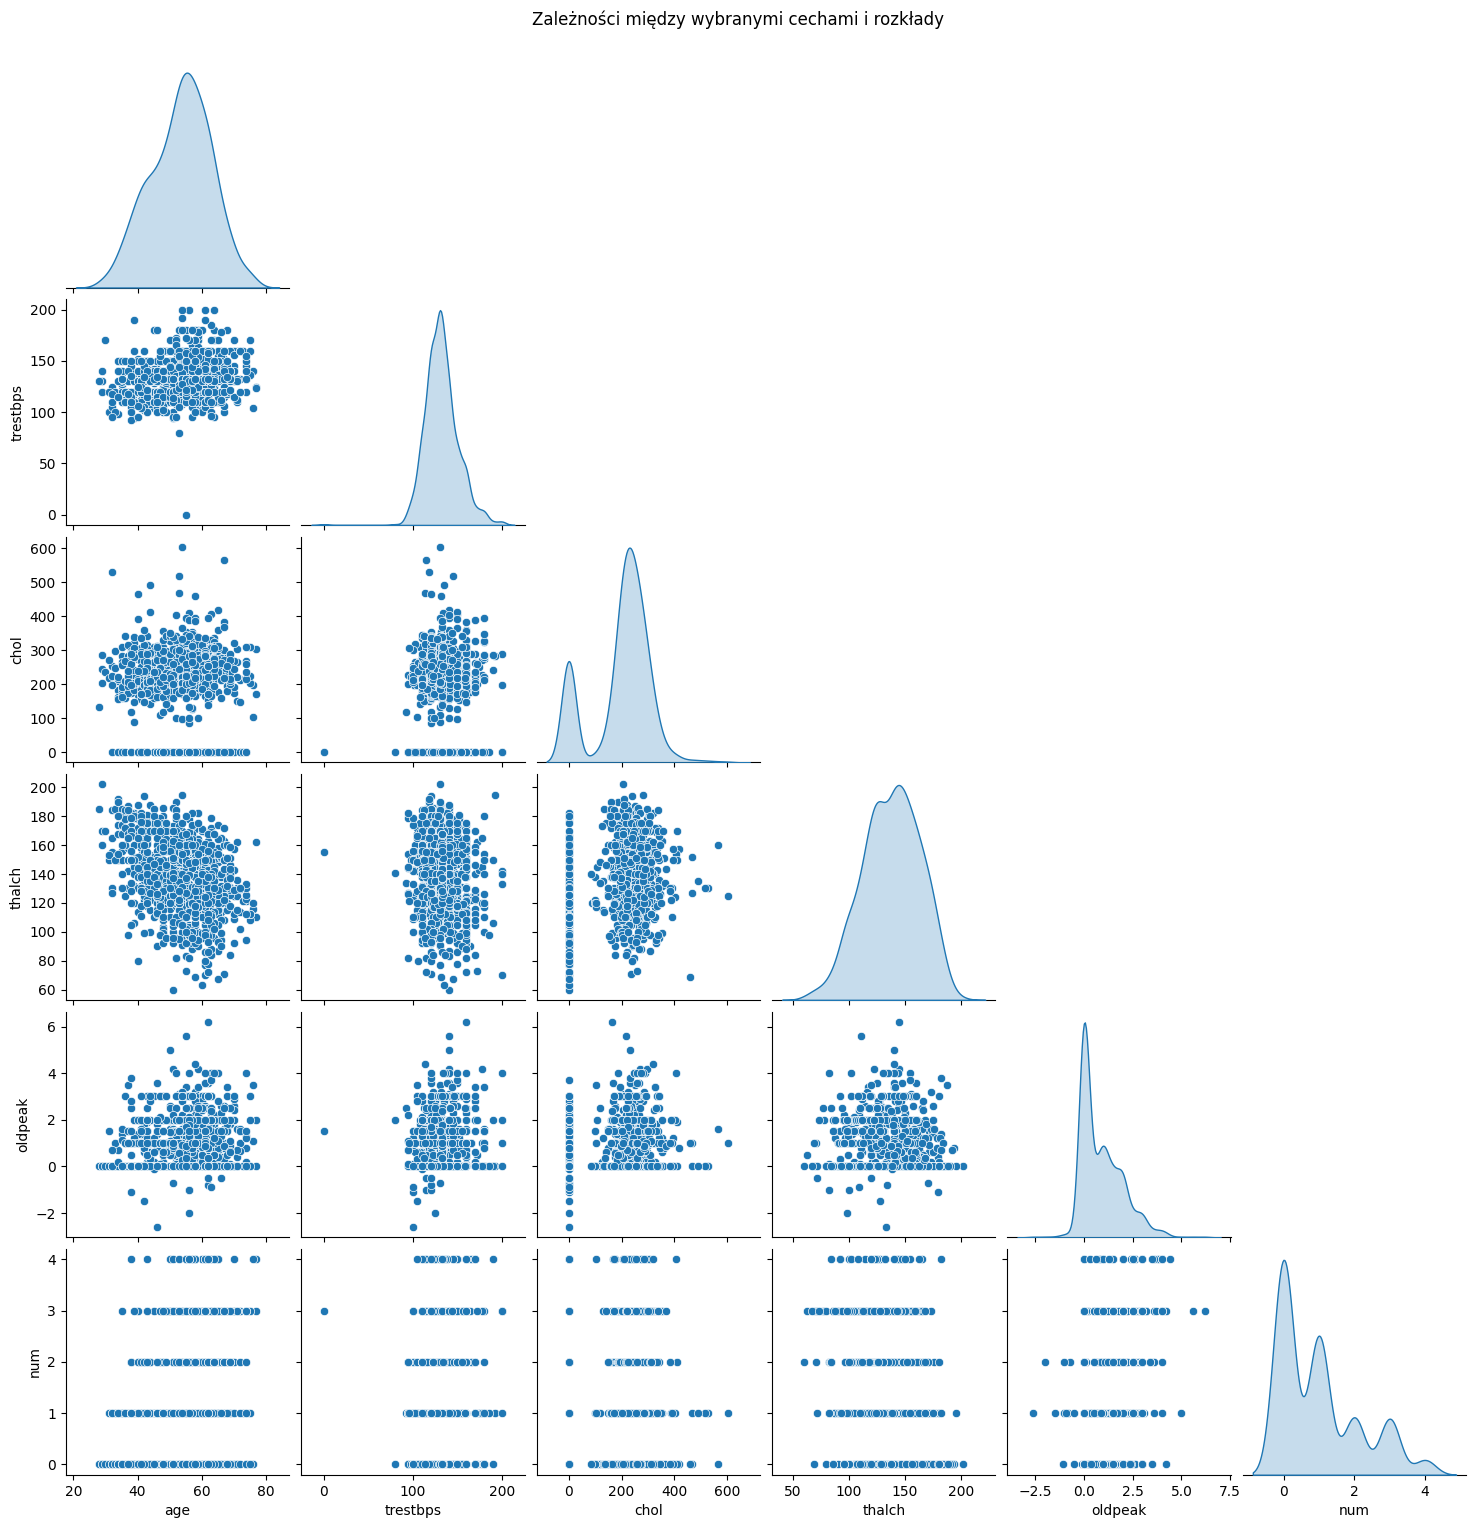

In [39]:
selected_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
sns.pairplot(df_encoded[selected_features + ['num']], diag_kind='kde', corner=True)
plt.suptitle("Zależności między wybranymi cechami i rozkłady", y=1.02)
plt.show()


🔍 Sprawdzanie wartości nieskończonych...

✅ Tworzenie histogramów dla 16 cech...
Cechy: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca', 'cp', 'restecg', 'slope', 'thal', 'cv_risk_score', 'heart_reserve', 'age_category', 'triple_risk', 'exercise_tolerance', 'has_disease']



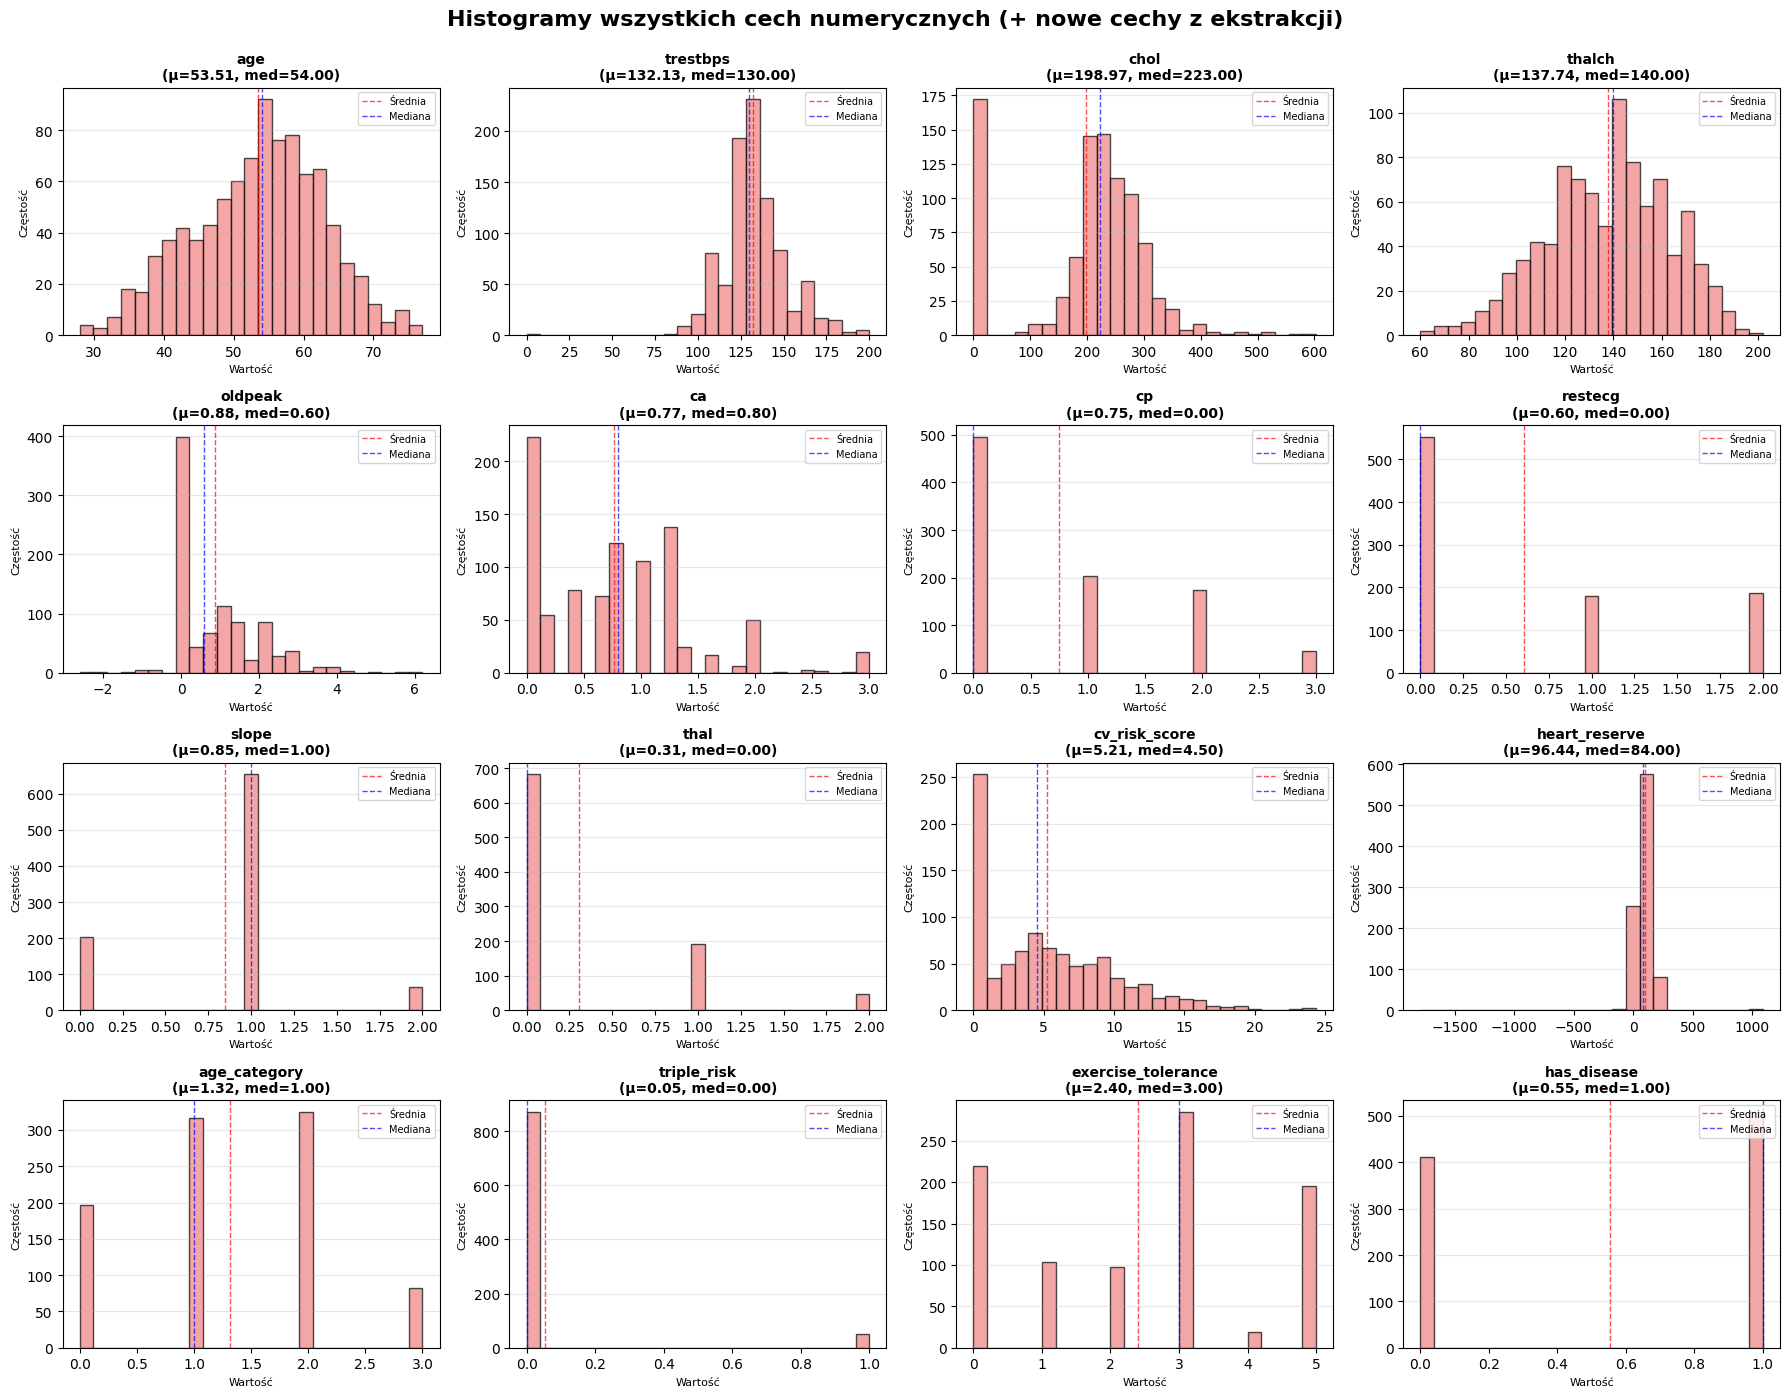


ANALIZA NOWYCH CECH - wizualizacja


/tmp/ipython-input-568177635.py:134: UserWarning: Glyph 127381 (\N{SQUARED NEW}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127381 (\N{SQUARED NEW}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


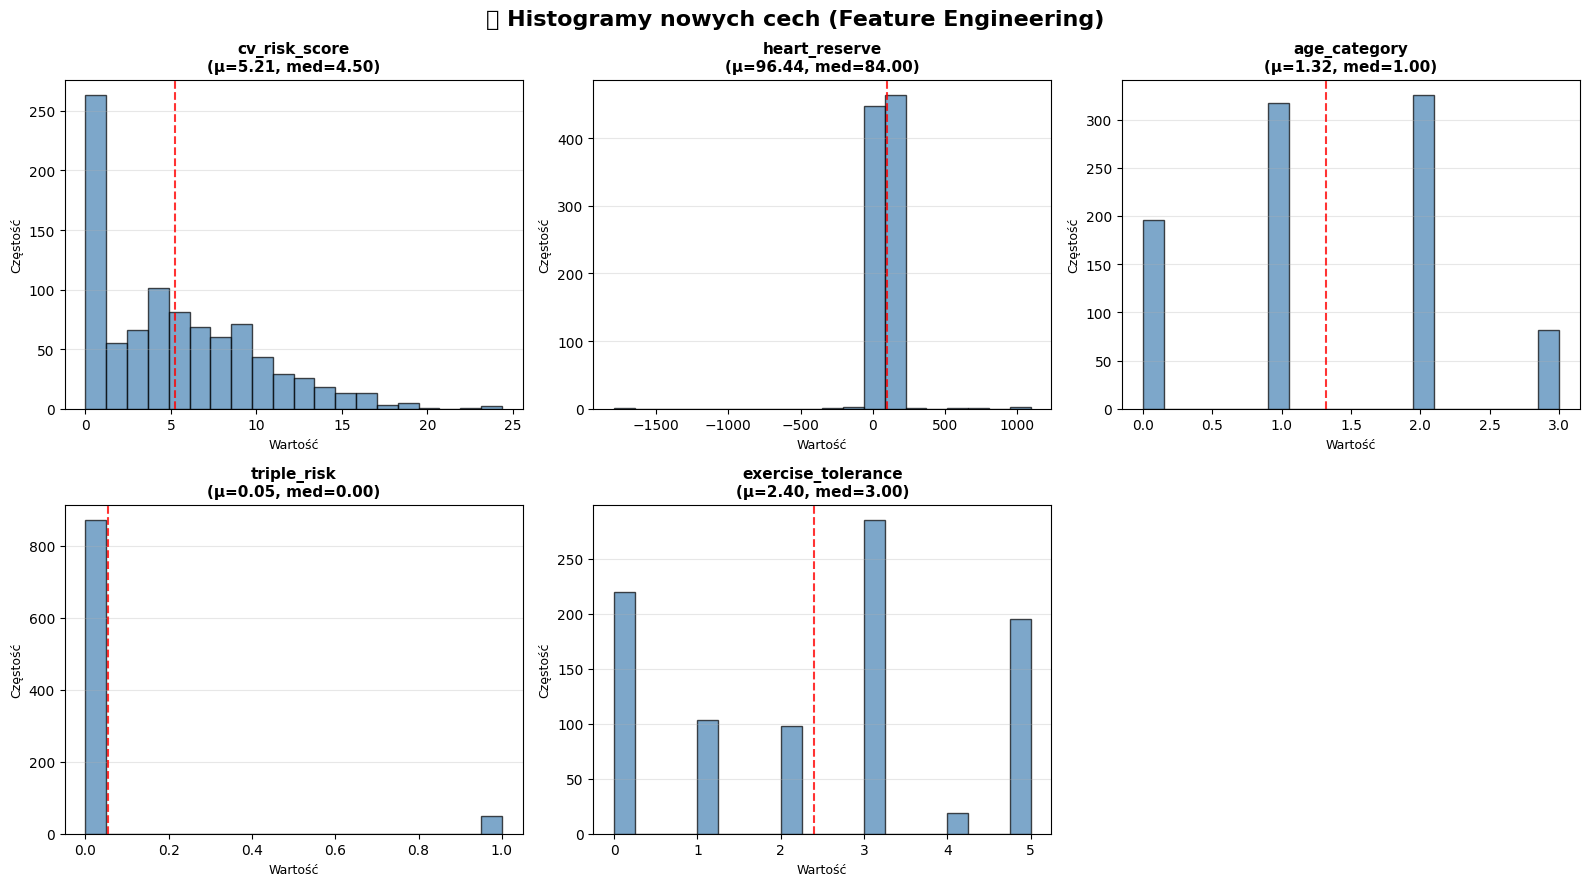


Statystyki opisowe dla nowych cech:
                    count   mean     std     min    25%   50%    75%      max
cv_risk_score       920.0   5.21    4.69     0.0   0.43   4.5    8.4    24.35
heart_reserve       920.0  96.44  101.28 -1790.0  50.00  84.0  140.0  1090.00
age_category        920.0   1.32    0.91     0.0   1.00   1.0    2.0     3.00
triple_risk         920.0   0.05    0.22     0.0   0.00   0.0    0.0     1.00
exercise_tolerance  920.0   2.40    1.79     0.0   1.00   3.0    3.0     5.00

ZALEŻNOŚĆ NOWYCH CECH OD CHOROBY (num)


/tmp/ipython-input-568177635.py:180: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


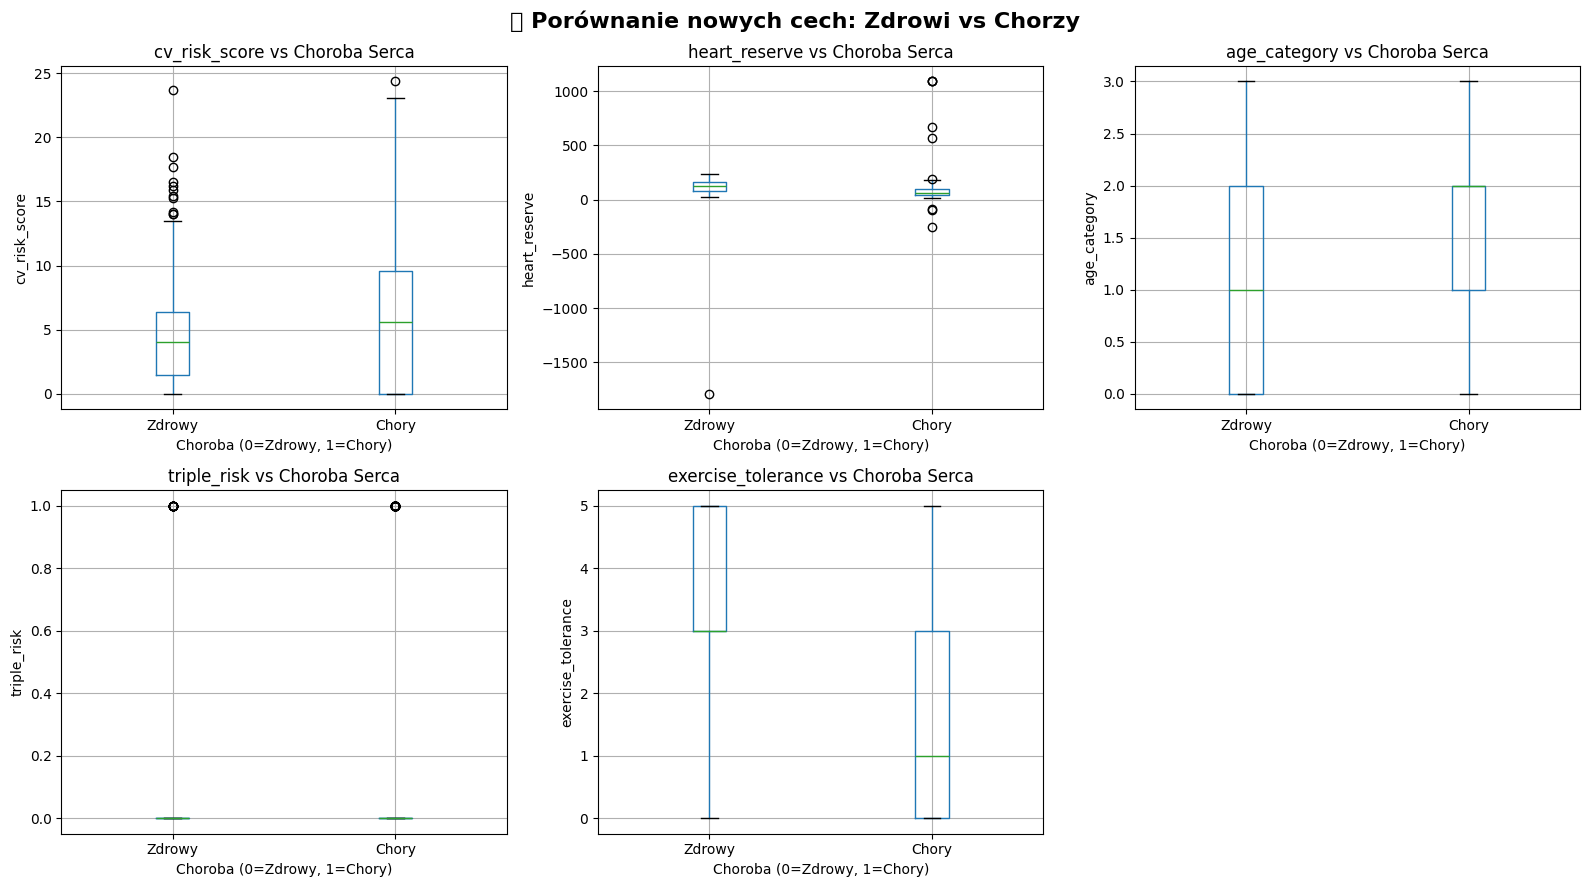


Średnie wartości nowych cech dla zdrowych vs chorych:
                cv_risk_score  heart_reserve  age_category  triple_risk  \
Zdrowy (num=0)           4.46         116.89          1.02         0.03   
Chory (num>0)            5.82          79.92          1.56         0.07   

                exercise_tolerance  
Zdrowy (num=0)                3.40  
Chory (num>0)                 1.59  


✅ Histogramy i analiza zakończone!


In [43]:
# =============================================================================
# HISTOGRAMY - wszystkie cechy numeryczne + nowe cechy
# =============================================================================
# ZASTĄP tym kodem ostatni blok z histogramami (od linii ~200 do końca)

import matplotlib.pyplot as plt
import numpy as np

# Wybierz wszystkie kolumny numeryczne (wykluczając id i kolumny binarne One-Hot)
numeric_cols = df_encoded.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Usuń niepotrzebne kolumny
cols_to_exclude = ['id', 'num']  # id i target nie potrzebują histogramów
numeric_cols = [col for col in numeric_cols if col not in cols_to_exclude]

# IMPORTANT: Usuń wartości inf i -inf przed tworzeniem histogramów
print("🔍 Sprawdzanie wartości nieskończonych...")
for col in numeric_cols:
    inf_count = np.isinf(df_encoded[col]).sum()
    if inf_count > 0:
        print(f"   ⚠️  {col}: znaleziono {inf_count} wartości inf - zastępuję NaN")
        df_encoded[col] = df_encoded[col].replace([np.inf, -np.inf], np.nan)

print(f"\n✅ Tworzenie histogramów dla {len(numeric_cols)} cech...")
print(f"Cechy: {numeric_cols}\n")

# Dynamiczne obliczenie layoutu (optymalny grid)
n_cols_plot = 4  # 4 kolumny w gridzie
n_rows_plot = int(np.ceil(len(numeric_cols) / n_cols_plot))

# Tworzenie figury z większą przestrzenią
fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(18, n_rows_plot * 3.5))
axes = axes.flatten()  # spłaszczenie do 1D array dla łatwiejszego iterowania

# Rysowanie histogramów
for idx, col in enumerate(numeric_cols):
    # Usuń NaN i sprawdź czy są dane
    data = df_encoded[col].dropna()

    if len(data) == 0:
        axes[idx].text(0.5, 0.5, f'{col}\n(brak danych)',
                      ha='center', va='center', fontsize=10)
        axes[idx].set_title(col, fontsize=10, fontweight='bold')
        continue

    # Rysuj histogram
    try:
        axes[idx].hist(
            data,
            bins=25,
            color='lightcoral',
            edgecolor='black',
            alpha=0.7
        )

        # Dodaj tytuł, średnią i medianę
        mean_val = data.mean()
        median_val = data.median()

        axes[idx].set_title(f'{col}\n(μ={mean_val:.2f}, med={median_val:.2f})',
                            fontsize=10, fontweight='bold')
        axes[idx].set_xlabel('Wartość', fontsize=8)
        axes[idx].set_ylabel('Częstość', fontsize=8)
        axes[idx].grid(axis='y', alpha=0.3)

        # Dodaj pionowe linie dla średniej (czerwona) i mediany (niebieska)
        axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Średnia')
        axes[idx].axvline(median_val, color='blue', linestyle='--', linewidth=1, alpha=0.7, label='Mediana')
        axes[idx].legend(fontsize=7, loc='upper right')

    except Exception as e:
        # Jeśli histogram się nie uda, pokaż info
        axes[idx].text(0.5, 0.5, f'{col}\n(błąd: {str(e)[:30]})',
                      ha='center', va='center', fontsize=8)
        axes[idx].set_title(col, fontsize=10, fontweight='bold')

# Usuń puste subploty (jeśli grid jest większy niż liczba cech)
for idx in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle("Histogramy wszystkich cech numerycznych (+ nowe cechy z ekstrakcji)",
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# =============================================================================
# BONUS: Histogramy TYLKO dla nowych cech (ładniejsza prezentacja)
# =============================================================================
print("\n" + "="*70)
print("ANALIZA NOWYCH CECH - wizualizacja")
print("="*70)

new_features = ['cv_risk_score', 'heart_reserve', 'age_category',
                'triple_risk', 'exercise_tolerance']

# Sprawdź które cechy istnieją
existing_new_features = [f for f in new_features if f in df_encoded.columns]

if existing_new_features:
    fig, axes = plt.subplots(2, 3, figsize=(16, 9))
    axes = axes.flatten()

    for idx, col in enumerate(existing_new_features):
        data = df_encoded[col].replace([np.inf, -np.inf], np.nan).dropna()

        if len(data) == 0:
            axes[idx].text(0.5, 0.5, f'{col}\n(brak danych)',
                          ha='center', va='center', fontsize=10)
            continue

        axes[idx].hist(
            data,
            bins=20,
            color='steelblue',
            edgecolor='black',
            alpha=0.7
        )

        mean_val = data.mean()
        median_val = data.median()

        axes[idx].set_title(f'{col}\n(μ={mean_val:.2f}, med={median_val:.2f})',
                            fontsize=11, fontweight='bold')
        axes[idx].set_xlabel('Wartość', fontsize=9)
        axes[idx].set_ylabel('Częstość', fontsize=9)
        axes[idx].grid(axis='y', alpha=0.3)
        axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=1.5, alpha=0.8)

    # Usuń ostatni pusty subplot
    fig.delaxes(axes[-1])

    plt.suptitle("🆕 Histogramy nowych cech (Feature Engineering)",
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Statystyki opisowe dla nowych cech (bez inf)
    print("\nStatystyki opisowe dla nowych cech:")
    new_features_clean = df_encoded[existing_new_features].replace([np.inf, -np.inf], np.nan)
    print(new_features_clean.describe().T.round(2))

# =============================================================================
# BONUS 2: Porównanie nowych cech z targetem (num)
# =============================================================================
if 'num' in df_encoded.columns:
    print("\n" + "="*70)
    print("ZALEŻNOŚĆ NOWYCH CECH OD CHOROBY (num)")
    print("="*70)

    # Sprawdź czy num jest ciągły czy kategoryczny
    df_encoded['has_disease'] = (df_encoded['num'] > 0).astype(int)

    fig, axes = plt.subplots(2, 3, figsize=(16, 9))
    axes = axes.flatten()

    for idx, col in enumerate(existing_new_features):
        # Usuń inf przed plotowaniem
        plot_data = df_encoded[[col, 'has_disease']].copy()
        plot_data[col] = plot_data[col].replace([np.inf, -np.inf], np.nan)
        plot_data = plot_data.dropna()

        if len(plot_data) == 0:
            axes[idx].text(0.5, 0.5, f'{col}\n(brak danych)',
                          ha='center', va='center', fontsize=10)
            continue

        # Box plot dla każdej nowej cechy vs choroba
        plot_data.boxplot(column=col, by='has_disease', ax=axes[idx])
        axes[idx].set_title(f'{col} vs Choroba Serca')
        axes[idx].set_xlabel('Choroba (0=Zdrowy, 1=Chory)')
        axes[idx].set_ylabel(col)
        plt.sca(axes[idx])
        plt.xticks([1, 2], ['Zdrowy', 'Chory'])

    # Usuń ostatni pusty subplot
    fig.delaxes(axes[-1])

    plt.suptitle("📊 Porównanie nowych cech: Zdrowi vs Chorzy",
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Statystyki grupowe (bez inf)
    print("\nŚrednie wartości nowych cech dla zdrowych vs chorych:")
    clean_features = df_encoded[existing_new_features].replace([np.inf, -np.inf], np.nan)
    df_temp = pd.concat([clean_features, df_encoded[['has_disease']]], axis=1)
    comparison = df_temp.groupby('has_disease')[existing_new_features].mean()
    comparison.index = ['Zdrowy (num=0)', 'Chory (num>0)']
    print(comparison.round(2))

    print("\n" + "="*70)

print("\n✅ Histogramy i analiza zakończone!")